In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
%matplotlib inline

In [2]:
import torch
torch.__version__

'1.7.0'

In [3]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader,random_split
from torchvision.utils import make_grid

In [4]:
dataset = ImageFolder("../input/amigosspectrogram/Arousal/Arousal",transform=ToTensor())

In [5]:
dataset.classes

['High', 'Low']

In [6]:
batch_size = 32
val_size = int(len(dataset) * 0.2)
train_size = len(dataset) - val_size

train_ds,val_ds = random_split(dataset,[train_size,val_size])

train_loader = DataLoader(train_ds,batch_size = batch_size,shuffle=True)
val_loader = DataLoader(val_ds,batch_size = batch_size,shuffle=True)

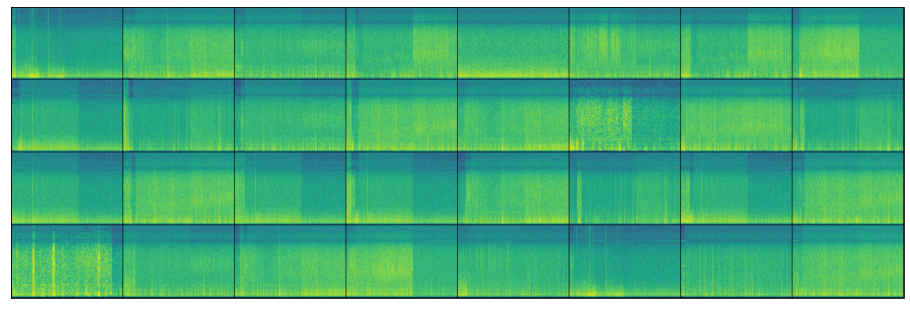

In [7]:
for images,label in train_loader:
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
    break

In [8]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))


@torch.no_grad()
def evaluate(model,val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

class ImageClassificationBase(nn.Module):

  def training_step(self,batch):
    images,labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    return loss

  def validation_step(self,batch):
    images,labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    acc = accuracy(out,labels)
    return {'val_loss':loss,'val_acc':acc}

  def validation_epoch_end(self,outputs):
    batch_loss = [out['val_loss'] for out in outputs]
    epoch_loss = torch.stack(batch_loss).mean()
    batch_acc = [out['val_acc'] for out in outputs]
    epoch_acc = torch.stack(batch_acc).mean()
    return {'val_loss':epoch_loss.item(),'val_acc':epoch_acc.item()}

  def epoch_end(self,epoch,result):
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [9]:
class CNN_Base(ImageClassificationBase):
    
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
        nn.Conv2d(3,32,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), 

        nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), 

        nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), 
        nn.AdaptiveAvgPool2d(1), 
        
        nn.Flatten(),
        nn.Linear(256,512),
        nn.ReLU(),
        nn.Linear(512,256),
        nn.ReLU(),
        nn.Linear(256,2)
        )
    
    def forward(self,xb):
        out = self.network(xb)
        return out

In [10]:
def fit(num_epochs,lr,train_loader,val_loader,model,opt_func=torch.optim.Adam):
    optimizer = opt_func(model.parameters(),lr)
    history = []
    for epoch in range(num_epochs):
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        results = evaluate(model,val_loader)
        train_loss = torch.stack(train_losses).mean().item()
        results['train_loss'] = train_loss
        model.epoch_end(epoch,results)
        history.append(results)
    return history

In [11]:

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [12]:
device = get_default_device()
device

device(type='cuda')

In [13]:
model = CNN_Base()
model

CNN_Base(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): AdaptiveAvgPool2d(output_size=1)
    (16): Flatten(start_dim=1, end_dim=-1)
    (17): Linear(in_features=256, out_features=512, bias=True)
    (18):

In [14]:
train_loader = DeviceDataLoader(train_loader,device)
val_loader= DeviceDataLoader(val_loader,device)
model = model.to(device)

In [18]:
history = fit(10,0.0001,train_loader,val_loader,model)

Epoch [0], train_loss: 0.6223, val_loss: 0.6225, val_acc: 0.6858
Epoch [1], train_loss: 0.6210, val_loss: 0.6132, val_acc: 0.6979
Epoch [2], train_loss: 0.6216, val_loss: 0.6128, val_acc: 0.6979
Epoch [3], train_loss: 0.6218, val_loss: 0.6030, val_acc: 0.7101
Epoch [4], train_loss: 0.6214, val_loss: 0.6225, val_acc: 0.6858
Epoch [5], train_loss: 0.6215, val_loss: 0.6129, val_acc: 0.6979
Epoch [6], train_loss: 0.6212, val_loss: 0.6128, val_acc: 0.6979
Epoch [7], train_loss: 0.6221, val_loss: 0.6225, val_acc: 0.6858
Epoch [8], train_loss: 0.6212, val_loss: 0.6129, val_acc: 0.6979
Epoch [9], train_loss: 0.6226, val_loss: 0.6225, val_acc: 0.6858


In [20]:
img,label = dataset[10]
img = img.unsqueeze(0)
img = img.to(device)
out = model(img)
print(out.detach())

tensor([[ 0.3809, -0.4092]], device='cuda:0')
